# Cosmogenic neutrinos from UHECR propagation

This notebook exemplifies how to predict fluxes of cosmogenic neutrinos produced via UHECR interactions with background photon fields (CMB, EBL). It is an extension of the example from notebook 03.
It considers that the sources are uniformly distributed and have a power-law spectrum with an exponential cut-off at some rigidity.
The simulation is done assuming this spectrum to be E^-1, but at the post-processing stage any desired spectral index can be obtained.

(This simulations may take a couple of minutes.)

### Assembling the simulation

A function to automatically perform the propagation of UHECR nuclei of atomic mass $A$ and atomic number $Z$.

Unlike in example 03, we must explicitly instruct the interaction modules to add the produced neutrinos to the simulation.
We could, likewise, toggle photons and electrons. However, this extremely time-consuming and could lead to memory problems. Therefore, this example only stores neutrinos.

We are studying neutrinos with energies as low as a fraction of a PeV, but we are not interested in UHECRs below ~1 EeV. To optimise the simulation performance, instead of choosing a single global break condition (`MinimumEnergy`), we use `MinimumEnergyPerParticleId`.

In [4]:
from crpropa import *


def simulate(A, Z, nEvents = 40000):
	# general options
	neutrinos = True
	photons = electrons = False
	energyRange = (0.5 * EeV, 1000 * EeV)
	distanceRange = (0., 4000. * Mpc)
	cmb = CMB()
	ebl = IRB_Dominguez11()
	outputFileCR = 'sim/05-sim1D-A_%02i_Z_%02i-CR.txt' % (A, Z)
	outputFileNu = 'sim/05-sim1D-A_%02i_Z_%02i-Nu.txt' % (A, Z)

	# source distribution: uniform with power-law spectrum
	position = SourceUniform1D(*distanceRange)
	direction = SourceDirection(Vector3d(-1, 0, 0)) # emit in the -x direction (1D simulation)
	redshifts = SourceRedshift1D() # takes the positions and assign the corresponding redshifts
	energySpectrum = SourcePowerLawSpectrum(*energyRange, -1)
	particleType = SourceParticleType(nucleusId(A, Z))
	source = Source()
	source.add(position)
	source.add(redshifts) 
	source.add(direction)
	source.add(energySpectrum)
	source.add(particleType)

	# outputs
	outputType = Output.Event1D
	outputCR = TextOutput(outputFileCR, outputType)
	outputCR.setEnergyScale(eV)
	outputCR.setLengthScale(Mpc)
	outputNu = TextOutput(outputFileNu, outputType)
	outputNu.setEnergyScale(eV)
	outputNu.setLengthScale(Mpc)

	# observers (for CRs and for neutrinos) 
	observerType = Observer1D()
	neutrinoVeto = ObserverNeutrinoVeto()
	nucleusVeto = ObserverNucleusVeto()
	photonVeto = ObserverPhotonVeto()
	electronVeto = ObserverElectronVeto()
	observerCR = Observer()
	observerCR.add(observerType)
	observerCR.add(neutrinoVeto)
	observerCR.add(photonVeto)
	observerCR.add(electronVeto)
	observerCR.onDetection(outputCR)
	observerNu = Observer()
	observerNu.add(observerType)
	observerNu.add(nucleusVeto)
	observerNu.add(photonVeto)
	observerNu.add(electronVeto)
	observerNu.onDetection(outputNu)

	# interactions: photodisintegration
	pdCMB = PhotoDisintegration(cmb)
	pdCMB.setHavePhotons(photons)
	pdEBL = PhotoDisintegration(ebl)
	pdEBL.setHavePhotons(photons)

	# interactions: photopion production
	pppCMB = PhotoPionProduction(cmb)
	pppCMB.setHavePhotons(photons)
	pppCMB.setHaveElectrons(electrons)
	pppCMB.setHaveNeutrinos(neutrinos)
	pppEBL = PhotoPionProduction(ebl)
	pppEBL.setHavePhotons(photons)
	pppEBL.setHaveElectrons(electrons)
	pppEBL.setHaveNeutrinos(neutrinos)

	# interactions: Bethe-Heitler pair production
	eppCMB = ElectronPairProduction(cmb)
	eppCMB.setHaveElectrons(electrons)
	eppEBL = ElectronPairProduction(ebl)
	eppEBL.setHaveElectrons(electrons)

	# decays
	nd = NuclearDecay()
	nd.setHavePhotons(photons)
	nd.setHaveElectrons(electrons)
	nd.setHaveNeutrinos(neutrinos)

	# adiabatic losses
	z = Redshift()

	# creating a list with all processes
	processes = [pdCMB, pdEBL, pppCMB, pppEBL, eppCMB, eppEBL, nd, z]

	# propagator: one-dimensional
	propagator = SimplePropagation(0.1 * kpc, 1 * Mpc)

	# break condition:  
	#  neutrinos: we are studying ~PeV-EeV energies, so E>10 TeV is suitable
	#  we are not interested in UHECRs with E<1 EeV
	breakEnergy = MinimumEnergyPerParticleId(1 * EeV) # global minimum energy 
	breakEnergy.add( 12, 10 * TeV) 
	breakEnergy.add(-12, 10 * TeV)
	breakEnergy.add( 14, 10 * TeV)
	breakEnergy.add(-14, 10 * TeV)
	breakEnergy.add( 16, 10 * TeV)
	breakEnergy.add(-16, 10 * TeV)


	# assemble simulation components
	sim = ModuleList()
	sim.add(propagator)
	for interaction in processes:
		sim.add(interaction)
	sim.add(observerCR)
	sim.add(observerNu)
	sim.add(breakEnergy)
	sim.setShowProgress(True)
	sim.run(source, nEvents, True)

	outputCR.close()
	outputNu.close()

	return outputFileCR, outputFileNu


simH_CR, simH_Nu = simulate( 1, 1)
simN_CR, simN_Nu = simulate(14, 7)


crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Mon Aug 21 19:33:44 2023 : [ Finished ] 100%    Needed: 00:00:27  - Finished at Mon Aug 21 19:34:11 2023
crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Mon Aug 21 19:34:12 2023 : [ Finished ] 100%    Needed: 00:01:04  - Finished at Mon Aug 21 19:35:16 2023


Now we proceed with the postprocessing of the simulation.
Note that we wish to simulate a spectrum $E^{-\alpha}$ with an exponential cut-off at rigidities $R_\mathrm{max}$.
Since we simulated a $E_0^{-1}$ spectrum, we must reweight the simulation to obtain the desired injection spectrum.

### Helper functions

Functions for reading the simulations and obtaining the spectrum are provided below, including the reweighting procedure.

In [5]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output.
	"""
	# infer header names
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]
	
	# read file
	df = pd.read_csv(filename, delimiter = '\t', comment = '#', names = names)

	return df

def reweightSimulation(df, alpha, Rmax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Rmax`: spectrum cuts off above Z Rmax, where Z is the atomic number of the nucleus \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0, z0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (z0 * Rmax))
	w = np.array([computeWeight(df['E0'][i], chargeNumber(int(df['ID0'][i]))) for i in range(len(df['E0']))])
	df[columnName] = w / np.sum(w)

def computeSpectra(dfCR, dfNu, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum of neutrinos and CRs.
	These two computations are done together to ensure a self-consistent normalisation.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	binsCR = np.logspace(17, 21, 20)
	yCR, edgesCR = np.histogram(dfCR['E'], bins = binsCR, weights = dfCR[columnName])
	xCR = edgesCR[:-1] + ((edgesCR[1:] - edgesCR[:-1]) / 2.)
	yCR /= np.diff(edgesCR)
	yCR *= (xCR ** 2) # for E^2 dN/dE
	
	binsNu = np.logspace(13, 21, 30)
	yNu, edgesNu = np.histogram(dfNu['E'], bins = binsNu, weights = dfNu[columnName])
	xNu = edgesNu[:-1] + ((edgesNu[1:] - edgesNu[:-1]) / 2.)
	yNu /= np.diff(edgesNu)
	yNu *= (xNu ** 2) # for E^2 dN/dE

	return xCR, yCR, xNu, yNu

### Read simulations

Now we read the simulation and study three scenarios with different combinations of spectral index and maximal rigidity.

In [6]:
dataH_CR = readSimulation(simH_CR)
dataH_Nu = readSimulation(simH_Nu)
dataN_CR = readSimulation(simN_CR)
dataN_Nu = readSimulation(simN_Nu)

a1, Rmax1 = 2.0, 6e19
a2, Rmax2 = 1.0, 4e18
reweightSimulation(dataH_CR, a1, Rmax1, columnName = 'W1')
reweightSimulation(dataH_Nu, a1, Rmax1, columnName = 'W1')
reweightSimulation(dataN_CR, a1, Rmax1, columnName = 'W1')
reweightSimulation(dataN_Nu, a1, Rmax1, columnName = 'W1')
reweightSimulation(dataH_CR, a2, Rmax2, columnName = 'W2')
reweightSimulation(dataH_Nu, a2, Rmax2, columnName = 'W2')
reweightSimulation(dataN_CR, a2, Rmax2, columnName = 'W2')
reweightSimulation(dataN_Nu, a2, Rmax2, columnName = 'W2')

xH_CR_1, yH_CR_1, xH_Nu_1, yH_Nu_1 = computeSpectra(dataH_CR, dataH_Nu, columnName = 'W1')
xN_CR_1, yN_CR_1, xN_Nu_1, yN_Nu_1 = computeSpectra(dataN_CR, dataN_Nu, columnName = 'W1')
xH_CR_2, yH_CR_2, xH_Nu_2, yH_Nu_2 = computeSpectra(dataH_CR, dataH_Nu, columnName = 'W2')
xN_CR_2, yN_CR_2, xN_Nu_2, yN_Nu_2 = computeSpectra(dataN_CR, dataN_Nu, columnName = 'W2')

### Plotting

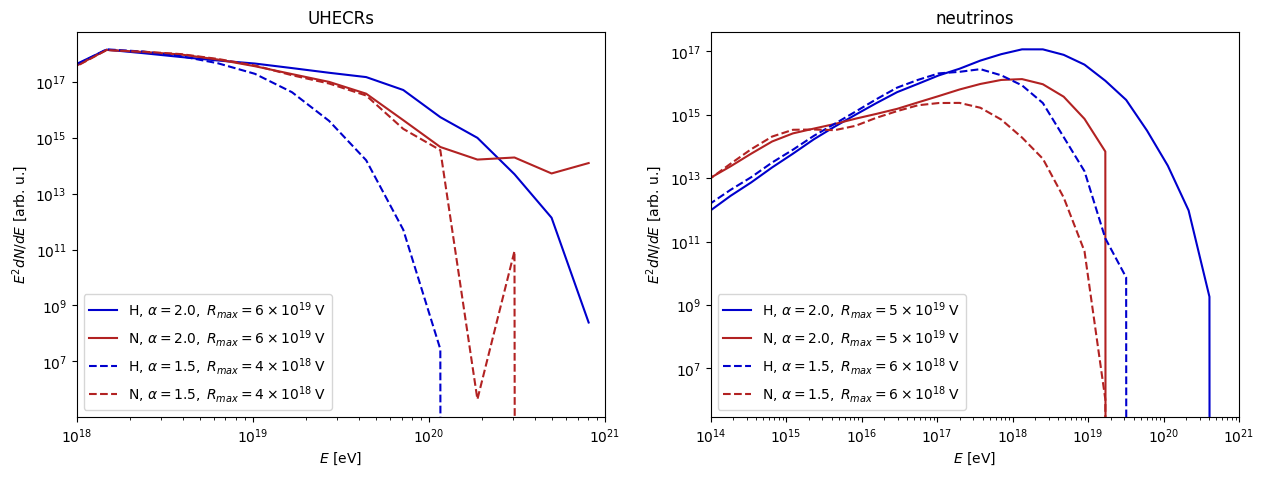

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ls1, ls2 = '-', '--'
cH, cN = 'mediumblue', 'firebrick'

ax1.plot(xH_CR_1, yH_CR_1, ls = ls1, c = cH, label = 'H, $\\alpha = 2.0, \\; R_{max} = 6 \\times 10^{19} \\; \\mathrm{V}$')
ax1.plot(xN_CR_1, yN_CR_1, ls = ls1, c = cN, label = 'N, $\\alpha = 2.0, \\; R_{max} = 6 \\times 10^{19} \\; \\mathrm{V}$')
ax1.plot(xH_CR_2, yH_CR_2, ls = ls2, c = cH, label = 'H, $\\alpha = 1.5, \\; R_{max} = 4 \\times 10^{18} \\; \\mathrm{V}$')
ax1.plot(xN_CR_2, yN_CR_2, ls = ls2, c = cN, label = 'N, $\\alpha = 1.5, \\; R_{max} = 4 \\times 10^{18} \\; \\mathrm{V}$')
ax1.set_title('UHECRs')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set(xlim = (1e18, 1e21))
ax1.set_ylabel('$E^2 dN/dE$ [arb. u.]')
ax1.set_xlabel('$E$ [eV]')
ax1.legend(loc = 'lower left')

ax2.plot(xH_Nu_1, yH_Nu_1, ls = ls1, c = cH, label = 'H, $\\alpha = 2.0, \\; R_{max} = 5 \\times 10^{19} \\; \\mathrm{V}$')
ax2.plot(xN_Nu_1, yN_Nu_1, ls = ls1, c = cN, label = 'N, $\\alpha = 2.0, \\; R_{max} = 5 \\times 10^{19} \\; \\mathrm{V}$')
ax2.plot(xH_Nu_2, yH_Nu_2, ls = ls2, c = cH, label = 'H, $\\alpha = 1.5, \\; R_{max} = 6 \\times 10^{18} \\; \\mathrm{V}$')
ax2.plot(xN_Nu_2, yN_Nu_2, ls = ls2, c = cN, label = 'N, $\\alpha = 1.5, \\; R_{max} = 6 \\times 10^{18} \\; \\mathrm{V}$')
ax2.set_title('neutrinos')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set(xlim = (1e14, 1e21))
ax2.set_ylabel('$E^2 dN/dE$ [arb. u.]')
ax2.set_xlabel('$E$ [eV]')
ax2.legend(loc = 'lower left');
